# Empirical study: Causal effect and causal inference

# Topic: COVID-19 mortality rate

__________________

## Research question and motivation

In [1]:
import numpy as np
from numpy.linalg import inv
import statsmodels.formula.api as smf

# Make print quality look significantly better.
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

import pandas as pd
from linearmodels import IV2SLS, IVLIML, IVGMM, IVGMMCUE
import linearmodels.iv as iv
import scipy.stats as stats
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

The purpose of this project is to identify the factors correlated with the COVID-19 mortality rate. We hope to increase understanding concerning factors that render some states more vulnerable to the virus than others. As coronavirus continues its spread across the globe, even modest but early advances in such knowledge could lead to a significant reduction in loss of life$.^{1}$

The infection fatality rate, the probability of dying for an infected person, is one of the essential features of the coronavirus disease 2019 (COVID-19) pandemic. The expected total mortality burden of COVID-19 is directly related to the infection fatality rate. Moreover, justification for various non-pharmacological public health interventions depends on the infection fatality rate. If the infection fatality rate is high, some stringent interventions that potentially also result in more noticeable collateral harms may be considered appropriate. Conversely, the same measures may fall short of acceptable risk-benefit thresholds, if the infection fatality rate is low$.^{2}$

We will examine Population Density and its effect on the target variable - Fatality Rate. 


Population density has an impact on the spread of the pandemic. Population density can be defined as a measurement of the average number of individuals per unit of geographic area (Liu et al. 2020)$.^{3}$ The higher the population density, the faster diseases can spread. Population density is likely just one of many key factors determining a specific location's vulnerability to the virus.  In smaller communities, the virus has targeted nursing homes, community houses, funeral parlors, and of course, cruise ships, which are like dense small cities at sea$.^{4}$


We chose mortality rate as our target variable as it is less likely than case rates (e.g., infection rate) to be distorted by local variations in testing policy. 


### Motivation for research 

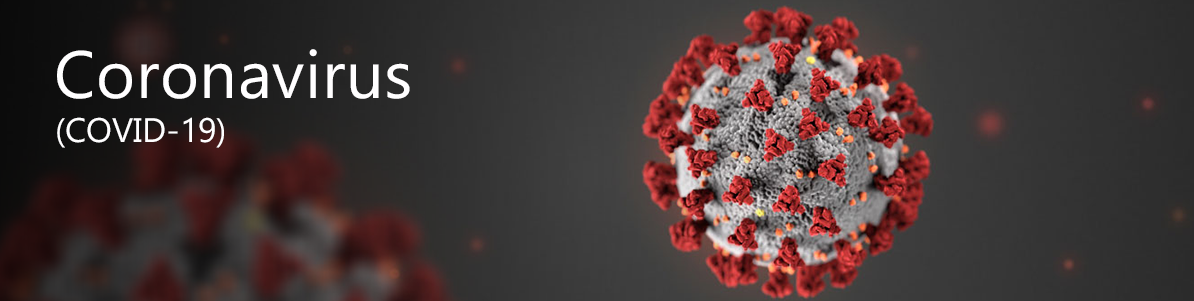

Based on Figure 1, the top 3 states with the highest mortality rate are New York, New Jersey, Massachusetts, and the bottom three states are Alaska, Utah, Wyoming. We would like to have a better understanding of 'Why Fatality Rate varies across states?'.

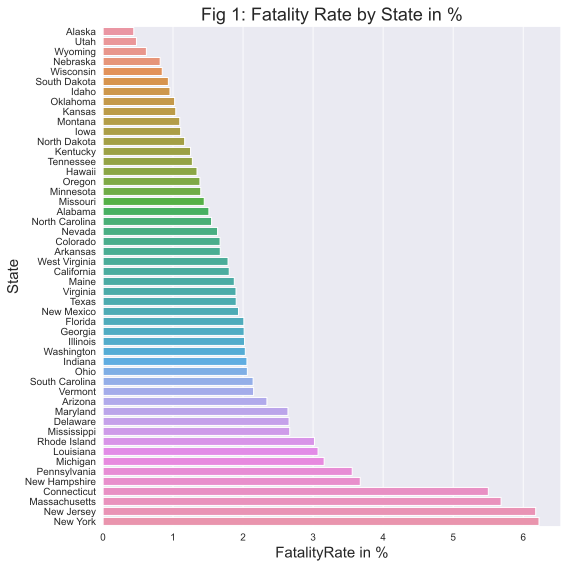

In [56]:
# Fatality Rate by State
plt.figure(figsize=(8,8))
# Barplot and sort bars
sns.barplot(x='FatalityRate',
            y="State", 
            data=main_df1, 
            order=main_df1.sort_values('FatalityRate').State)
# Set labels
plt.xlabel("FatalityRate in %", size=15)
plt.ylabel("State", size=15)
plt.title("Fig 1: Fatality Rate by State in %", size=18)
plt.tight_layout()

Based on Figure 2, the top 3 states with the highest population density are New Jersey, Rhode Island, Massachusetts, and the bottom three states are Alaska, Wyoming, Montana.

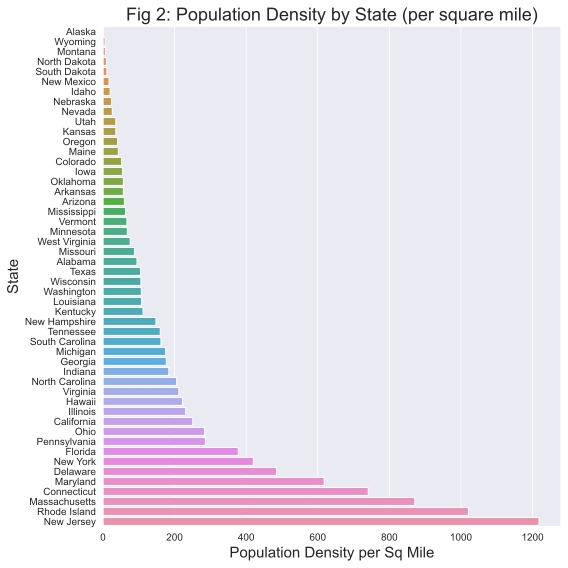

In [57]:
# Population Density by State
plt.figure(figsize=(8,8))
# Make barplot and sort bars
sns.barplot(x='DEN',
            y="State", 
            data=main_df1, 
            order=main_df1.sort_values('DEN').State)
# Set labels
plt.xlabel("Population Density per Sq Mile", size=15)
plt.ylabel("State", size=15)
plt.title("Fig 2: Population Density by State (per square mile)", size=18)
plt.tight_layout()

As per the results from the charts above (Fig 1 and Fig 2), we will examine the effect of Population Density on Fatality Rate.

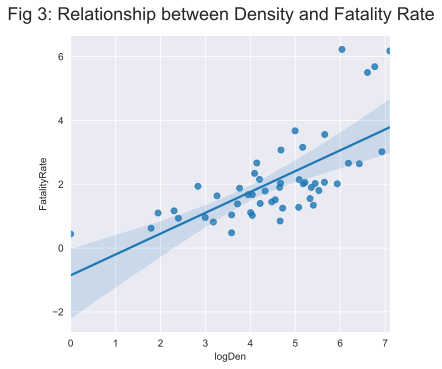

In [62]:
main_df1['logDen'] = np.log(main_df1['DEN'])
g = sns.lmplot(x='logDen', y='FatalityRate', data=main_df1)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Fig 3: Relationship between Density and Fatality Rate',size=18);

### Target and Focal Variables

**Fatality Rate**- Dependent Variable

**Population Density** (Social Variable) - the increased population density increases exposure to all communicable pathogens as it is getting more difficult for people to keep social distance. On the other side, people living in rural areas are more likely to maintain social distance. Therefore, people living in areas with high population density are more likely to be infected with a heavy viral load which could increase the severity of COVID-19 and leads to death. We expect the coefficient of this variable to be positive$.^{1}$

#### Uploading Datasets and cleaning up the data

In [ ]:
xls = pd.ExcelFile('Revised_dataset_V2.xlsx')
df1 = pd.read_excel(xls, 'DataSet V5')
df2 = pd.read_excel(xls, 'List of data variables')
df3 = pd.read_csv('xCGRT_US_latest.csv', encoding='unicode_escape')

In [3]:
# Check the columns in df1
list(df1)

['No.',
 'State',
 'HCExpenditures',
 'HCExpenditures_Level',
 'HI_Coverage_Total_Pop%',
 'HI_Coverage_Total_Pop_Level',
 'Uninsured_Coverage_Total_Pop%',
 'Highschool_GraduateRate%',
 'Highschool_GraduateRate_Level',
 'Bachelors_degree_GraduateRate%',
 'Bachelors_degree_GraduateRate_Level',
 'PopulationDensity_mi2',
 'Total_Number_Residents',
 'Total_Number_Residents_Level',
 'Total_Hospital_Admissions',
 'Number_of_COVID_Cases',
 'Number_of_COVID_Cases_Level',
 'Infection_Rate_Total_Test_as_denominator%',
 'Infection_Rate_Total_Residents_as_denominator%',
 'Number_of_Deaths_from_COVID',
 'COVID_Fatality_Rate%',
 'Total_COVID_Tests_with_Results',
 'Total_COVID_Tests_with_Results_Level',
 'Daily_Covid_Tests_per_mil',
 'MedianIncome_Annual',
 'MedianIncome_Annual_Level',
 'NoDoctor_12Months%',
 'SeverelyObese%',
 'Share_of_adults_under_age_65_at_risk%',
 'Share_of_adults_under_age_65_at_risk_Level',
 'Share_of_adults_over_age_65_at_risk%',
 'Share_of_adults_over_age_65_at_risk_Level',
 

In [4]:
df3['Date'].head()

0    20200101
1    20200102
2    20200103
3    20200104
4    20200105
Name: Date, dtype: int64

In [5]:
df3['Date'] = pd.to_datetime(df3['Date'], format='%Y%m%d')

In [6]:
df3['State'] = df3['RegionName']
df3['State'].unique()

array([nan, 'Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California',
       'Colorado', 'Connecticut', 'Washington DC', 'Delaware', 'Florida',
       'Georgia', 'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana',
       'Kansas', 'Kentucky', 'Louisiana', 'Massachusetts', 'Maryland',
       'Maine', 'Michigan', 'Minnesota', 'Missouri', 'Mississippi',
       'Montana', 'North Carolina', 'North Dakota', 'Nebraska',
       'New Hampshire', 'New Jersey', 'New Mexico', 'Nevada', 'New York',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Virginia', 'Vermont', 'Washington', 'Wisconsin', 'West Virginia',
       'Wyoming'], dtype=object)

In [7]:
main = pd.merge(df1, df3, how='inner', on="State")

In [8]:
main.head()

,No.,State,HCExpenditures,HCExpenditures_Level,HI_Coverage_Total_Pop%,HI_Coverage_Total_Pop_Level,Uninsured_Coverage_Total_Pop%,Highschool_GraduateRate%,Highschool_GraduateRate_Level,Bachelors_degree_GraduateRate%,...,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,1,Alabama,35263,1,90.3,0,9.7,85.3,0,24.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Alabama,35263,1,90.3,0,9.7,85.3,0,24.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,Alabama,35263,1,90.3,0,9.7,85.3,0,24.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,Alabama,35263,1,90.3,0,9.7,85.3,0,24.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,Alabama,35263,1,90.3,0,9.7,85.3,0,24.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
len(main.columns)

141

In [10]:
# Subsetting by Date to be '11-13-2020' as this is when most of the data was collected
main_df = main[(main['Date']== "2020-11-13")]

In [11]:
# Checking all the columns in DataFrame and choose columns of interest only
for col in main_df.columns:
    print(col)

No.
State
HCExpenditures
HCExpenditures_Level
HI_Coverage_Total_Pop%
HI_Coverage_Total_Pop_Level
Uninsured_Coverage_Total_Pop%
Highschool_GraduateRate%
Highschool_GraduateRate_Level
Bachelors_degree_GraduateRate%
Bachelors_degree_GraduateRate_Level
PopulationDensity_mi2
Total_Number_Residents
Total_Number_Residents_Level
Total_Hospital_Admissions
Number_of_COVID_Cases
Number_of_COVID_Cases_Level
Infection_Rate_Total_Test_as_denominator%
Infection_Rate_Total_Residents_as_denominator%
Number_of_Deaths_from_COVID
COVID_Fatality_Rate%
Total_COVID_Tests_with_Results
Total_COVID_Tests_with_Results_Level
Daily_Covid_Tests_per_mil
MedianIncome_Annual
MedianIncome_Annual_Level
NoDoctor_12Months%
SeverelyObese%
Share_of_adults_under_age_65_at_risk%
Share_of_adults_under_age_65_at_risk_Level
Share_of_adults_over_age_65_at_risk%
Share_of_adults_over_age_65_at_risk_Level
Diabetes_death_rate%
Health_Care_Expenditures_per_Capita
Health_Care_Expenditures_per_Capita_Level
Total_Hospital_Beds
Mortality_

In [12]:
# Selecting only columns of our interest into one dataframe
main_df1 = main_df.filter([
    "State", 'HCExpenditures', 'Health_Care_Expenditures_per_Capita',
    'MedianIncome_Annual', 'Uninsured_Coverage_Total_Pop%',
    'Population_Ages_65+%', 'PopulationDensity_mi2', 'Total_Hospital_Beds',
    'Face_Mask_Adoption%', 'Total_Gross_State_Product',
    'GovernmentResponseIndexForDisplay', 'StringencyIndexForDisplay',
    'EconomicSupportIndexForDisplay', 'ContainmentHealthIndexForDisplay',
    'Bachelors_degree_GraduateRate%',
    'Infection_Rate_Total_Test_as_denominator%',
    'Infection_Rate_Total_Residents_as_denominator%', 'COVID_Fatality_Rate%',
    'Daily_Covid_Tests_per_mil', 'NoDoctor_12Months%',
    'Share_of_adults_over_age_65_at_risk%', 'Unemployment_Claims',
    'Adults_with_no_Personal_Doctor%',
    'Health_Professional_Shortage_Area', 'Primary_Care_Physicians',
    'VotePercentage_Trump%', 'Total_Number_Residents', 'Number_of_COVID_Cases',
    'Number_of_Deaths_from_COVID', 'Total_COVID_Tests_with_Results',
    'ICU_Beds', 'Effective Reproduction Number', 'LifeExpectancyatBirth',
    'UrbanizationRate', 'SeverelyObese%', 'Gini','Population_Ages_65+_Level','Share_of_adults_over_age_65_at_risk_Level','Unemployment_Rate%']).reset_index(drop=True)

In [13]:
# Raname Some of the Variables
main_df1.rename(columns={'HCExpenditures': 'HC_Exp'}, inplace=True)
main_df1.rename(
    columns={'Uninsured_Coverage_Total_Pop%': 'Uninsured_TotalPop_rate'},
    inplace=True)
main_df1.rename(columns={'Population_Ages_65+%': 'Pop_above_65_rate'},
                inplace=True)
main_df1.rename(columns={'Face_Mask_Adoption%': 'Face_Mask_Adoption_rate'},
                inplace=True)
main_df1.rename(
    columns={'Bachelors_degree_GraduateRate%': 'Bachelors_Graduate_Rate'},
    inplace=True)
main_df1.rename(columns={'Infection_Rate_Total_Test_as_denominator%': 'IR'},
                inplace=True)
main_df1.rename(
    columns={'Infection_Rate_Total_Residents_as_denominator%': 'IR_pop'},
    inplace=True)
main_df1.rename(columns={'COVID_Fatality_Rate%': 'FatalityRate'}, inplace=True)

In [14]:
main_df1.to_csv("finaldataset.csv", index = False)

## Description of Datasets

### COVID 19 Dataset
We collected 47 variables covering two data types: medical and demographic.

The COVID 19 dataset was collected from different sources: 
* Government organizations(CDC, Agency for Healthcare, Bureau of Health, Labor Statistics, Department of Labour, US Census Bureau, etc. )
* Non-profit foundations (Kaiser Family Foundation, Johns Hopkins University, Wikipedia)
* For profit organizations (YouGov, NBC News)

The data for collected on a state level (51 states)

Note: please see **Appendix 1** for a full list of data sources. 

### Policy Dataset 

Dataset was collected from The Oxford COVID-19 Government Response Tracker (OxCGRT) website.

OxCGRT provides information on 20 indicators of government responses. 

Eight of the policy indicators (C1-C8) record information on containment and closure policies, such as school closures and restrictions in movement. 

Four of the indicators (E1-E4) record economic policies, such as income support to citizens or provision of foreign aid. Eight of the indicators (H1-H8) record health system policies such as the COVID-19 testing regime, emergency investments into healthcare and most recently, vaccination policies.

The data from the 20 indicators are aggregated into a set of four common indices, reporting a number between 1 and 100 to reflect the level of government action on the topics in question:

* Overall Government Response Index(all indicators). It records how the response of governments has varied over all indicators in the database, becoming stronger or weaker over the course of the outbreak.
* Containment and Health index (all C and H indicators). It combines ‘lockdown’ restrictions and closures with measures such as testing policy and contact tracing, short term investment in healthcare, and, investment in vaccines.
* Economic Support Index (all E indicators). It records measures such as income support and debt relief
* Original Stringency Index (all indicators). It records the strictness of ‘lockdown style’ policies that primarily restrict people’s behaviour).


Note: please see **Appendix 1** for a full list of data sources.

### Visualization of Combined Datasets

The combined dataset has no missing values or duplicates. Please refer to the graphs below for details. 


In [15]:
print(main_df1.shape)

(50, 38)


In [16]:
# Info on Combined Dataset
main_df1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 38 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   State                                      50 non-null     object 
 1   HC_Exp                                     50 non-null     int64  
 2   Health_Care_Expenditures_per_Capita        50 non-null     int64  
 3   MedianIncome_Annual                        50 non-null     int64  
 4   Uninsured_TotalPop_rate                    50 non-null     float64
 5   Pop_above_65_rate                          50 non-null     float64
 6   PopulationDensity_mi2                      50 non-null     int64  
 7   Total_Hospital_Beds                        50 non-null     float64
 8   Face_Mask_Adoption_rate                    50 non-null     float64
 9   GovernmentResponseIndexForDisplay          50 non-null     float64
 10  StringencyIndexForDisplay   

In [17]:
# Basic Statistical Summary
main_df1.describe().T

,count,mean,std,min,25%,50%,75%,max
HC_Exp,50.0,5.109908e+04,5.614452e+04,4856.000000,1.522600e+04,3.531100e+04,6.109000e+04,2.919890e+05
Health_Care_Expenditures_per_Capita,50.0,8.259920e+03,1.157627e+03,5982.000000,7.381000e+03,8.091500e+03,8.917500e+03,1.106400e+04
MedianIncome_Annual,50.0,5.979260e+04,9.854763e+03,43469.000000,5.291050e+04,5.828650e+04,6.749200e+04,8.077600e+04
Uninsured_TotalPop_rate,50.0,8.468000e+00,3.065505e+00,3.000000,6.400000e+00,7.950000e+00,1.017500e+01,1.840000e+01
Pop_above_65_rate,50.0,1.649000e+01,1.882817e+00,11.100000,1.570000e+01,1.645000e+01,1.742500e+01,2.060000e+01
PopulationDensity_mi2,50.0,2.000800e+02,2.661631e+02,1.000000,4.525000e+01,1.055000e+02,2.195000e+02,1.218000e+03
Total_Hospital_Beds,50.0,2.600000e+00,7.145714e-01,1.600000,2.100000e+00,2.450000e+00,3.075000e+00,4.800000e+00
Face_Mask_Adoption_rate,50.0,4.036000e+01,7.241490e+00,23.000000,3.600000e+01,3.900000e+01,4.500000e+01,5.800000e+01
GovernmentResponseIndexForDisplay,50.0,4.867660e+01,1.142430e+01,21.090000,3.971250e+01,4.857000e+01,5.540500e+01,7.500000e+01
StringencyIndexForDisplay,50.0,4.474100e+01,1.294311e+01,7.410000,3.657000e+01,4.352000e+01,5.254750e+01,7.593000e+01


#### Missing Values

In [18]:
# No missing values
main_df1.isna().sum()

State                                        0
HC_Exp                                       0
Health_Care_Expenditures_per_Capita          0
MedianIncome_Annual                          0
Uninsured_TotalPop_rate                      0
Pop_above_65_rate                            0
PopulationDensity_mi2                        0
Total_Hospital_Beds                          0
Face_Mask_Adoption_rate                      0
GovernmentResponseIndexForDisplay            0
StringencyIndexForDisplay                    0
EconomicSupportIndexForDisplay               0
ContainmentHealthIndexForDisplay             0
Bachelors_Graduate_Rate                      0
IR                                           0
IR_pop                                       0
FatalityRate                                 0
Daily_Covid_Tests_per_mil                    0
NoDoctor_12Months%                           0
Share_of_adults_over_age_65_at_risk%         0
Unemployment_Claims                          0
Adults_with_n

In [19]:
# No duplicates
duplicate_entries = main_df1[main_df1.duplicated()]
duplicate_entries.shape

(0, 38)

#### Histoplots
We want to find more insights into the distribution and relationship between variables.

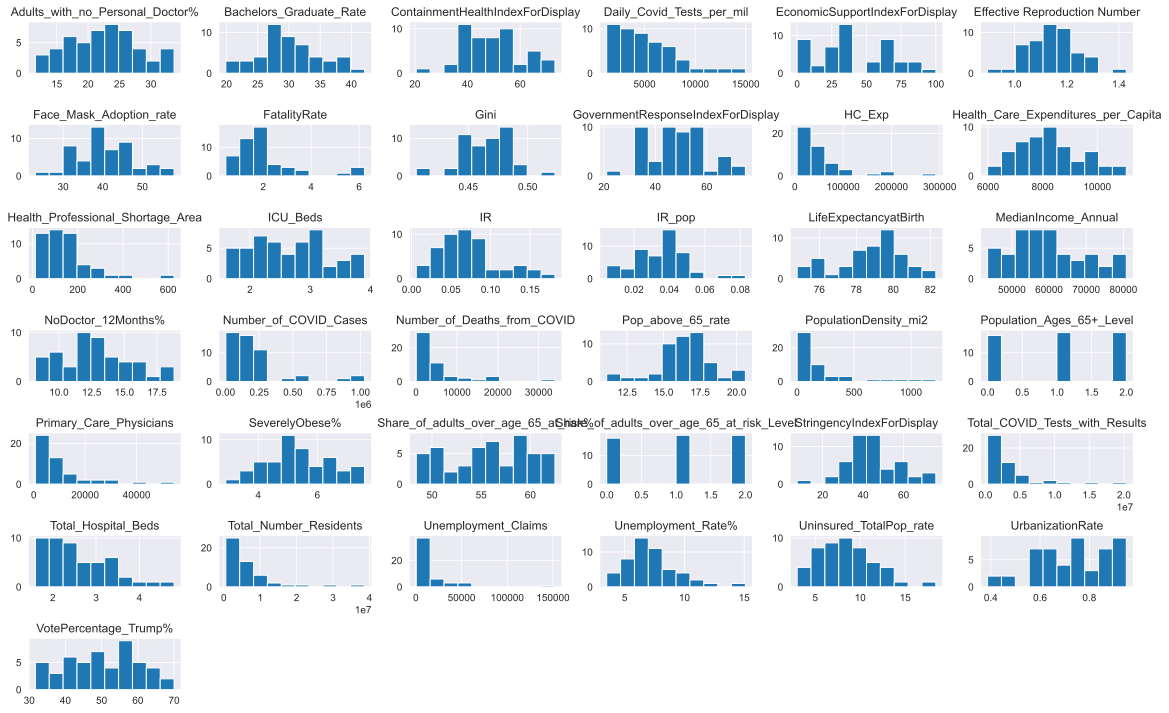

In [20]:
# Histoplots - checking data skewness
main_df1.hist(bins=10, figsize=(16,10))
plt.tight_layout()
plt.subplots_adjust(hspace=1) 
plt.show()

#### Correlation Matrix Heatmap

Samples of **Positive Correlation** are:

* 'No Doctor for the last 12 months and 'Uninsured Population'
* 'Median Income' and 'Life Expectancy at birth'
* 'Unemployment Claim' and 'Health Care Expenditure'


Samples of **Negative Correlation** are:
* 'Infection Rate' and 'Stringency Index'
* 'Severe Obesity' and 'Life Expectancy at Birth'
* 'Health Care Expenditure per capita' and 'Uninsured total population rate' 


**Note: Correlation does not imply causation**

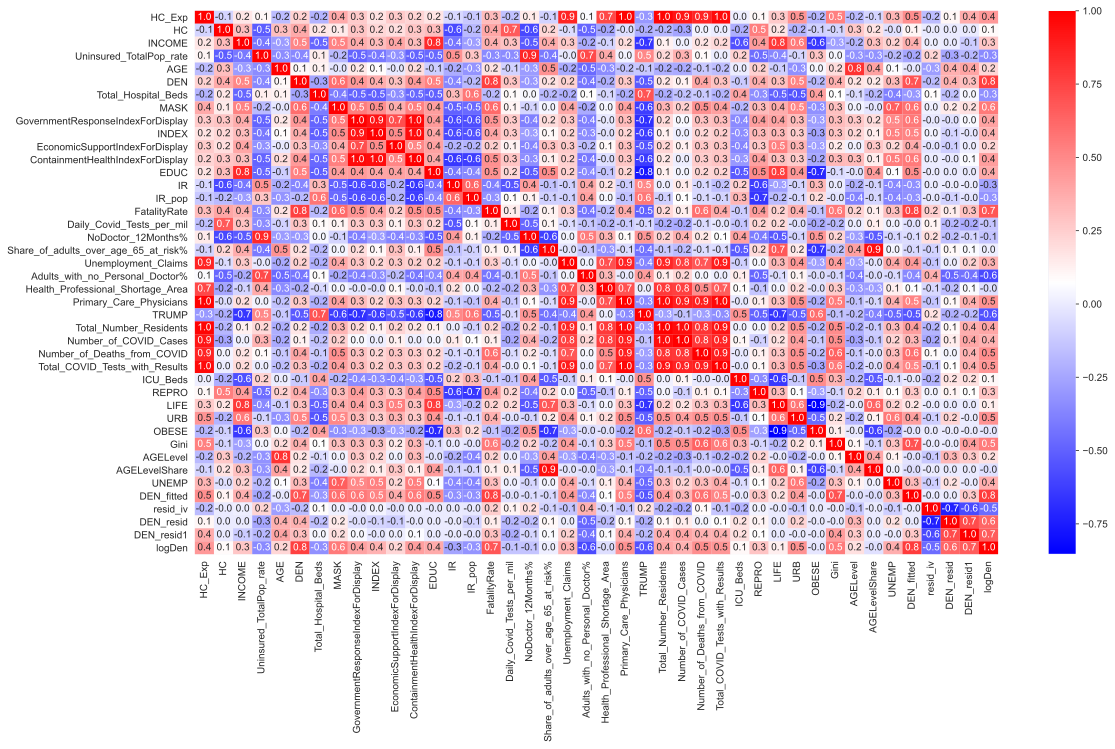

In [63]:
# Correlation Matrix
plt.figure(figsize=(18, 10))
sns.heatmap(main_df1.corr(), 
            cmap='bwr', 
            annot=True,
           fmt=".1f",
            annot_kws={'size':10}) ;

#### Renaming of Variables

In [23]:
main_df1.rename(columns={'PopulationDensity_mi2': 'DEN'}, inplace=True)
main_df1.rename(columns={'Pop_above_65_rate': 'AGE'}, inplace=True)
main_df1.rename(columns={'Face_Mask_Adoption_rate': 'MASK'}, inplace=True)
main_df1.rename(columns={'Bachelors_Graduate_Rate': 'EDUC'},inplace=True)  ## How much % of population is graduated
main_df1.rename(columns={'Health_Care_Expenditures_per_Capita': 'HC'}, inplace=True)
main_df1.rename(columns={'MedianIncome_Annual': 'INCOME'}, inplace=True)
main_df1.rename(columns={'StringencyIndexForDisplay': 'INDEX'}, inplace=True)
main_df1.rename(columns={'LifeExpectancyatBirth': 'LIFE'}, inplace=True)
main_df1.rename(columns={'UrbanizationRate': 'URB'}, inplace=True)
main_df1.rename(columns={'SeverelyObese%': 'OBESE'}, inplace=True)
main_df1.rename(columns={'Effective Reproduction Number': 'REPRO'},inplace=True)
main_df1.rename(columns={'VotePercentage_Trump%': 'TRUMP'}, inplace=True)
main_df1.rename(columns={'Population_Ages_65+_Level': 'AGELevel'}, inplace=True)
main_df1.rename(columns={'Share_of_adults_over_age_65_at_risk_Level': 'AGELevelShare'}, inplace=True)
main_df1.rename(columns={'Unemployment_Rate%': 'UNEMP'}, inplace=True)

In [24]:
main_df1.head()

,State,HC_Exp,HC,INCOME,Uninsured_TotalPop_rate,AGE,DEN,Total_Hospital_Beds,MASK,GovernmentResponseIndexForDisplay,...,Total_COVID_Tests_with_Results,ICU_Beds,REPRO,LIFE,URB,OBESE,Gini,AGELevel,AGELevelShare,UNEMP
0,Alabama,35263,7281,48123,9.7,16.9,95,3.1,38.0,36.46,...,1421590,3.9,1.032640,75.5,0.590,7.0,0.4847,1,0,6.6
1,Alaska,8151,11064,73181,11.5,11.8,1,2.2,42.0,52.08,...,844666,1.8,1.196418,79.0,0.660,5.6,0.4081,0,0,7.2
2,Arizona,43356,6452,56581,11.1,17.5,60,1.9,36.0,48.70,...,1923506,2.5,1.113547,80.0,0.898,4.8,0.4713,2,2,6.7
3,Arkansas,21980,7408,45869,9.1,17.0,57,3.2,39.0,51.04,...,1470147,2.9,1.116197,76.0,0.562,7.0,0.4719,1,0,7.3
4,California,291989,7549,71805,7.8,14.3,251,1.8,52.0,65.89,...,20342072,2.1,1.132834,81.7,0.950,3.6,0.4899,0,1,11.0


## Models and Results

Simple Linear Regression:  $$ \text {Fatality Rate}= \beta_0 + \beta_1 \text*{Population Density}+e$$ 

with $\beta$ the **average causal effect** of Population Density on Fatality Rate


The **null hypothesis** is: $$\mathbb{H}_{0}: \beta=\beta_{0}$$ 

The **alternative hypothesis** is: $$\mathbb{H}_{1}: \beta \neq \beta_{0}$$ 

Null hypothesis states that the true value of $\beta$ equals the hypothesized value $\beta_0$.

The alternative hypothesis states that the true value of $\beta$ does not equal the hypothesized value.

**Our main goal is to assess whether or not a coefficient 𝛽 equals a specific value 𝛽0.**



### Simple Regression & Forward Selection 

In order to alleviate omitted variables bias, we need to think about finding control variables, which may be directly correlated to focal  𝑥 (Population Density) and directly influence  𝑦(Fatality Rate from COVID-19).
Here you can see a list of confounding variables:

- Population Density  - DEN
- Population Ages 65+% - AGELevelShare
- Health Care Expenditures per Capita - HC
- Bachelors Degree Graduate Rate  - EDUC
- SeverelyObese% - OBESE
- Life Expectancy at Birth - LIFE
- Infection Rate -IR

#### Population Density 

REG1: Population Density is the Focal 'X' and Fatality Rate is dependent variable 'Y'

Population Density (Social Variable) - the increased population density increases exposure to all communicable pathogens as it is getting more difficult for people to keep social distance. 

While people living  in areas that are not so populated are more likely to maintain some sort of social distance. Therefore, people living in areas with high population density are more likely to be infected with a heavy viral load which could increase the severity of COVID-19 and leads to death. Therefore, we expect the coefficient of this variable to be positive.

In [26]:
# Step 1: Simple Linear Regression
reg1 = smf.ols(formula='FatalityRate ~ np.log(DEN)', data=main_df1)
results_1 = reg1.fit()

print('results_1.summary(): \n{}\n'.format(results_1.summary()))

results_1.summary(): 
                            OLS Regression Results                            
Dep. Variable:           FatalityRate   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     41.87
Date:                Fri, 06 Aug 2021   Prob (F-statistic):           4.76e-08
Time:                        08:46:03   Log-Likelihood:                -70.009
No. Observations:                  50   AIC:                             144.0
Df Residuals:                      48   BIC:                             147.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.8548      

**Note: The coefficient for population density is significant as p-value is 0.000**

#### Share of adults over age 65 at risk Level
Population Age 65+% - the coefficient is expected to be positive as an increase in population over 65 years of age are more prone to die from pneumonia and respiratory failure caused by COVID-19.

Definition of variable 'Share of adults over age 65 at risk Level': Older adults (ages 65 or older, rather than 60 and older) with heart disease, chronic obstructive pulmonary disease (COPD), uncontrolled asthma, diabetes, or a BMI greater than 40$.^{1}$

In [27]:
reg_2 = smf.ols(
    formula=
    'FatalityRate ~  np.log(DEN) + AGELevelShare',
    data=main_df1)
results_2 = reg_2.fit()
print('results_2.summary(): \n{}\n'.format(results_2.summary()))

results_2.summary(): 
                            OLS Regression Results                            
Dep. Variable:           FatalityRate   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     22.62
Date:                Fri, 06 Aug 2021   Prob (F-statistic):           1.31e-07
Time:                        08:48:09   Log-Likelihood:                -68.832
No. Observations:                  50   AIC:                             143.7
Df Residuals:                      47   BIC:                             149.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.1445

**Note: The coefficient for population density slightly increased but it is still significant as p-value is 0.000**

#### Health Care Expenditures per Capita
Health Care Expenditures per Capita -  better Health Care system means that patients who get infected with COVID-19 are able to get treatment on time and less prone to die. It is expected to have a negative effect on the death rate as an increase in Health Care Expenditure implied better healthcare for the patients infected and prone to COVID-19 infection and death$.^{1}$

In [28]:
reg_3 = smf.ols(
    formula=
    'FatalityRate ~  np.log(DEN)+ AGELevelShare+ HC',
    data=main_df1)
results_3 = reg_3.fit()
print('results_3.summary(): \n{}\n'.format(results_3.summary()))

results_3.summary(): 
                            OLS Regression Results                            
Dep. Variable:           FatalityRate   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     21.90
Date:                Fri, 06 Aug 2021   Prob (F-statistic):           5.89e-09
Time:                        08:49:56   Log-Likelihood:                -63.510
No. Observations:                  50   AIC:                             135.0
Df Residuals:                      46   BIC:                             142.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.0018

**Note: The coefficient for population density slightly dropped but it is still significant as p-value is 0.000**

#### Bachelors Degree Graduation Rate

Bachelors Degree Graduate Rate (Social Variable) - lack of education was also expected to harm the COVID-19 mortality rates, as a better-educated population is more informed about the prevention and treatment of COVID-19.

In [29]:
reg_4 = smf.ols(
    formula=
    'FatalityRate ~  np.log(DEN) + AGELevelShare + HC+ EDUC',
    data=main_df1)
results_4 = reg_4.fit()
print('results_4.summary(): \n{}\n'.format(results_4.summary()))

results_4.summary(): 
                            OLS Regression Results                            
Dep. Variable:           FatalityRate   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     16.63
Date:                Fri, 06 Aug 2021   Prob (F-statistic):           1.95e-08
Time:                        08:51:00   Log-Likelihood:                -62.999
No. Observations:                  50   AIC:                             136.0
Df Residuals:                      45   BIC:                             145.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.4401

**Note: The coefficient for population density keeps dropping slightly but it is still significant as p-value is 0.000**

#### Obesity 
Obesity increases the risk for hospitalization, ICU admission, IMV requirement, and death among patients with COVID-19. Patients who are older and have pre-existing chronic medical conditions, including obesity, cardiovascular diseases, diabetes, cancers, and chronic respiratory diseases, and kidney diseases, were found to be vulnerable to severe COVID-19.^{1}$

In [30]:
reg_5 = smf.ols(
    formula=
    'FatalityRate ~  np.log(DEN) + AGELevelShare+ HC+ EDUC + OBESE',
    data=main_df1)
results_5 = reg_5.fit()
print('results_5.summary(): \n{}\n'.format(results_5.summary()))

results_5.summary(): 
                            OLS Regression Results                            
Dep. Variable:           FatalityRate   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     13.02
Date:                Fri, 06 Aug 2021   Prob (F-statistic):           8.59e-08
Time:                        08:52:07   Log-Likelihood:                -62.992
No. Observations:                  50   AIC:                             138.0
Df Residuals:                      44   BIC:                             149.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.6231

**Note: The coefficient for population density is getting more stable and  continues to hold significant  p-value of 0.000**

#### Life expectancy at birth

The coefficient of 'Life Expectancy at Birth' could be positive or negative, depending on how you look at it. Greater life expectancy at birth is an indication of good health of the population with a good immune system, which can fight the disease; therefore, 'Life Expectancy at birth' should have a positive coefficient.

At the same time a greater life expectancy at birth implies people live longer with aging, and thus more prone to die of COVID-19 if infected. In this case, it can have a negative coefficient$.^{1}$

In [31]:
reg_6 = smf.ols(
    formula=
    'FatalityRate ~  np.log(DEN) + AGELevelShare + HC+ EDUC + OBESE + LIFE',
    data=main_df1)
results_6 = reg_6.fit()
print('results_6.summary(): \n{}\n'.format(results_6.summary()))

results_6.summary(): 
                            OLS Regression Results                            
Dep. Variable:           FatalityRate   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     10.64
Date:                Fri, 06 Aug 2021   Prob (F-statistic):           3.17e-07
Time:                        08:54:44   Log-Likelihood:                -62.933
No. Observations:                  50   AIC:                             139.9
Df Residuals:                      43   BIC:                             153.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.4342

**Note: The coefficient for population density is getting more stable (slightly increased) and  continues to hold significant  p-value of 0.000**

#### Infection Rate 
If you have more people with COVID-19, chances of its transmission to vulnerable group of people increases. 

In [32]:
reg_7 = smf.ols(
    formula=
    'FatalityRate ~  np.log(DEN) + AGELevelShare + HC+ EDUC + OBESE + LIFE + IR',
    data=main_df1)
results_7 = reg_7.fit()
print('results_7.summary(): \n{}\n'.format(results_7.summary()))

results_7.summary(): 
                            OLS Regression Results                            
Dep. Variable:           FatalityRate   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     8.911
Date:                Fri, 06 Aug 2021   Prob (F-statistic):           1.10e-06
Time:                        08:55:14   Log-Likelihood:                -62.931
No. Observations:                  50   AIC:                             141.9
Df Residuals:                      42   BIC:                             157.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.4874

**Note: The magnitude  for population density keeps getting more stable and  continues to hold significant  p-value of 0.000. We stop adding confounding factors at this point.**

### Multiple Regression

$$ \text {FatalityRate}= \beta_0 + \beta_1 \text*{DEN}+\beta_2 \text*{AGELevelShare}+\beta_3 \text*{HC}+\beta_4  \text*{EDUC}+\beta_5 \text*{OBESE}+\beta_6 \text*{LIFE}+\beta_7 \text*{IR}+e$$ 

In [33]:
# Consider multiple regression
reg_mul = smf.ols(
    formula=
    'FatalityRate ~  np.log(DEN) + AGELevelShare + HC+ EDUC + OBESE + LIFE + IR',
    data=main_df1)
results_mul = reg_mul.fit()
print('results_mul.summary(): \n{}\n'.format(results_mul.summary()))

results_mul.summary(): 
                            OLS Regression Results                            
Dep. Variable:           FatalityRate   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     8.911
Date:                Fri, 06 Aug 2021   Prob (F-statistic):           1.10e-06
Time:                        08:56:13   Log-Likelihood:                -62.931
No. Observations:                  50   AIC:                             141.9
Df Residuals:                      42   BIC:                             157.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.48

#### Conditional Variance Matrix

Covariance measures the directional relationship between the returns on two variables. A positive covariance means that variables move together while a negative covariance means they move inversely.

In [34]:
 # Call the conditional variance matrix from results object
results_mul.cov_params()

,Intercept,np.log(DEN),AGELevelShare,HC,EDUC,OBESE,LIFE,IR
Intercept,181.576247,0.088223,0.708482,1.923086e-06,0.198039,-2.236193,-2.246712,4.959904
np.log(DEN),0.088223,0.013039,-0.000199,4.163843e-06,-0.002669,-0.010265,-0.000703,0.138351
AGELevelShare,0.708482,-0.000199,0.050838,-9.730771e-06,0.001474,0.015735,-0.010016,-0.274747
HC,0.000002,0.000004,-0.000010,2.490510e-08,-0.000002,-0.000016,-0.000001,0.000467
EDUC,0.198039,-0.002669,0.001474,-2.167276e-06,0.002542,0.003785,-0.003383,-0.002142
OBESE,-2.236193,-0.010265,0.015735,-1.554670e-05,0.003785,0.069676,0.024627,-0.487527
LIFE,-2.246712,-0.000703,-0.010016,-1.278145e-06,-0.003383,0.024627,0.028531,-0.103547
IR,4.959904,0.138351,-0.274747,4.667036e-04,-0.002142,-0.487527,-0.103547,23.676045


#### Confidence Interval for all betas

In [35]:
# Check Confidence Interval for all betas
results_mul.conf_int()

,0,1
Intercept,-27.681147,26.706248
np.log(DEN),0.350720,0.811602
AGELevelShare,-0.339000,0.571046
HC,0.000018,0.000655
EDUC,-0.060608,0.142879
OBESE,-0.548138,0.517259
LIFE,-0.392627,0.289127
IR,-10.073805,9.565374


####  Residuals Histoplot 

<AxesSubplot:ylabel='Count'>

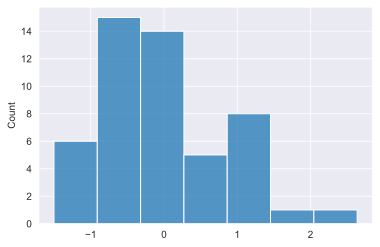

In [36]:
# Extract the residuals and plot
sns.histplot(results_mul.resid)

##  Heteroscedasticity Testing

### Definition

In regression analysis, **heteroscedasticity** refers to the unequal scatter of residuals. Specifically, it refers to the case where there is a systematic change in the spread of the residuals over the range of measured values.

Heteroscedasticity is a problem because ordinary least squares (**OLS**) regression assumes that the residuals come from a population that has **homoscedasticity**, which means constant variance. 

When heteroscedasticity is present in a regression analysis, the results of the analysis become hard to trust.

One way to determine if heteroscedasticity is present in a regression analysis is to use a Breusch-Pagan Test.

### Bresuch-Pagan test

In [38]:
#perform Bresuch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(results_mul.resid, results_mul.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 13.40185856622188),
 ('p-value', 0.06290182057306624),
 ('f-value', 2.1971375662020947),
 ('f p-value', 0.05388233204640314)]

As per the above, the Lagrange multiplier statistic for the test is **13.401** and the corresponding p-value is **0.0629**. Because this p-value is not less than 0.05, we fail to reject the null hypothesis. 

**We do not have sufficient evidence to say that heteroscedasticity is present in the regression model.**

## Hypothesis Testing

### Null hypothesis
**H0: beta_j = 0**


### t statistic
The t-test assesses whether the beta coefficient is significantly different from zero. 

In [39]:
# Two-sided hypothesis testing
# Null hypothesis: beta_j = 0
# In "General Procedure of Hypothesis Testing" we know the critical value is
stats.t.ppf(1 - 0.05 / 2, df=results_mul.df_resid)

2.018081697095881

In [40]:
# Reproduce t-statistic:
tstat = results_mul.params / results_mul.bse
print(f'tstat: \n{tstat}\n')

tstat: 
Intercept       -0.036174
np.log(DEN)      5.089495
AGELevelShare    0.514577
HC               2.130258
EDUC             0.815920
OBESE           -0.058492
LIFE            -0.306371
IR              -0.052245
dtype: float64



In [41]:
np.abs(tstat) > stats.t.ppf(1 - 0.05 / 2, df=results_mul.df_resid)

Intercept        False
np.log(DEN)       True
AGELevelShare    False
HC                True
EDUC             False
OBESE            False
LIFE             False
IR               False
dtype: bool

**Result: We can see that in hypothesis testing for Population Density we will reject H0  in favor of H1 and conclude that beta j is significantly different from zero.**

In [42]:
# We can easily compute the p values for equivalent test
# Reproduce p value:
pval = 2 * stats.t.cdf(-abs(tstat), df=results_mul.df_resid)
print(f'pval: \n{pval}\n')
pval < 0.05

pval: 
[9.71314753e-01 7.95749740e-06 6.09545996e-01 3.90514073e-02
 4.19149424e-01 9.53634134e-01 7.60835719e-01 9.58580924e-01]



array([False,  True, False,  True, False, False, False, False])

In [43]:
# Automated T-test:
hypotheses = ['np.log(DEN) = 0']
ttest = results_mul.t_test(hypotheses)
tstat = ttest.statistic[0][0]
tpval = ttest.pvalue
print(f'tstat: {tstat}\n')
print(f'tpval: {tpval}\n')

tstat: 5.0894952733745535

tpval: 7.957497399142922e-06



**P-value is below 0.05, so we reject Null Hypothesis and conclude that beta is significantly different from zero.**

## Endogeneity Handling


We need to consider if both the dependent variable and a regressor are simultaneously determined or they can theoretically affect each other in different scenarios. If this is the case, then the variables should be treated as endogenous.

$$ \text {Fatality Rate}= \beta_0 + \beta_1 \text*{Population Density}+e$$ 

If COVID-19 Fatality Rate is affected by **unobserved**  'Wealth of the population' in a particular state, and individuals with higher wealth choose to live in bigger cities with higher Population Density, then $e$  contains unobserved Wealth, so Population Density and $e$ will be _positively correlated_.

Hence Population Density is **endogenous**.


In order to **identify** the _unknown_ $\boldsymbol{\beta}$ in **structural model**, we need the help of **IVs** to transform the **structural model** into two **linear projection models**.

 In order to handle **endogeneity**, we need to find **instruments**, which are determined outside the system for $(y_i ,\boldsymbol{x}_{2i} )$, causally determine $\boldsymbol{x}_{2i}$, but do not causally determine $y_i$ except through $\boldsymbol{x}_{2i}$.  
 
Presents of IV can be used to estimate consistently the parameters in equation.

The reason for choosing 2SLS over OLS is that we think OLS estimators beta0 and beta1 are inconsistent due to correlation between x and u.

IV must be: 
1) Uncorrelated with other unobserved factors affecting FatalityRate  
2) It should not have direct affect on FatalityRate \
3) It must be correlated with Population Density 



Null Hypothesis: $\mathbf{H}_0: \delta_1 = 0$

Failing to reject $\mathbf{H}_0: \delta_1 = 0$ indicates that no obvious evidence for **endogeneity** of $y_2$

We reject the null hypothesis that DEN is exogenous and conclude that DEN is indeed an endogenous variable.

### IV Selection 


An ideal instrumental variable affects the regressor (Population Density) but does not directly influence the dependent variable (Covid-19 Fatality Rate) except through the indirect effect on the regressor. 

**Median Income Annual**  and **Gini Index** are potential IV choices:
* If a state has High Annual Median Income, it indicates that Population Density will be higher in that state as more people will migrate to the state  trying to find a job.
* However, **Median Income Annual** does not directly affect if a person gets infected by Covid-19 and dies from it, so should not have a direct effect on Covid-19 Fatality Rate

* Gini Index - is a measure of statistical dispersion intended to represent the income inequality or wealth inequality within a nation or any other group of people.

To get the **consistent estimator** for $\boldsymbol{\beta}$, we introduce  **Two-Stage Least Squares** 

### 2SLS 

In [47]:
# 1st stage (reduced form):
reg_redf = smf.ols(formula='np.log(DEN) ~ AGELevelShare + HC+ EDUC + OBESE +  LIFE + IR + Gini + INCOME', #GINI AND INCOME ARE IV
                   data=main_df1)
results_redf = reg_redf.fit()
main_df1['DEN_fitted'] = results_redf.fittedvalues

# Print regression table:
table_redf = pd.DataFrame({'b': round(results_redf.params, 4),
                           'se': round(results_redf.bse, 4),
                           't': round(results_redf.tvalues, 4),
                           'pval': round(results_redf.pvalues, 4)})
print(f'table_redf: \n{table_redf}\n')

table_redf: 
                     b       se       t    pval
Intercept     -22.4724  16.6658 -1.3484  0.1849
AGELevelShare   0.0885   0.2617  0.3382  0.7370
HC             -0.0002   0.0002 -1.3948  0.1706
EDUC            0.1080   0.0606  1.7804  0.0824
OBESE           0.6464   0.2625  2.4623  0.0181
LIFE            0.0034   0.2157  0.0158  0.9875
IR             -7.1001   4.9768 -1.4266  0.1613
Gini           40.3526   7.4471  5.4186  0.0000
INCOME          0.0001   0.0000  1.5961  0.1181



In [45]:
# 2nd stage:
reg_secstg = smf.ols(formula='FatalityRate ~ DEN_fitted + AGELevelShare + HC+ EDUC + OBESE +  LIFE + IR',
                     data=main_df1)
results_secstg = reg_secstg.fit()

# Print regression table:
table_secstg = pd.DataFrame({'b': round(results_secstg.params, 4),
                             'se': round(results_secstg.bse, 4),
                             't': round(results_secstg.tvalues, 4),
                             'pval': round(results_secstg.pvalues, 4)})
print(f'table_secstg: \n{table_secstg}\n')

table_secstg: 
                    b       se       t    pval
Intercept      2.8813  11.4743  0.2511  0.8030
DEN_fitted     1.0791   0.1495  7.2160  0.0000
AGELevelShare  0.1084   0.1916  0.5659  0.5745
HC             0.0005   0.0001  3.5646  0.0009
EDUC          -0.0608   0.0488 -1.2465  0.2195
OBESE         -0.4074   0.2415 -1.6871  0.0990
LIFE          -0.0786   0.1436 -0.5473  0.5871
IR             5.0287   4.3067  1.1676  0.2495



In [46]:
# IV automatically:
reg_iv = iv.IV2SLS.from_formula(
    formula='FatalityRate ~ 1 + AGELevelShare + HC+ EDUC + OBESE +  LIFE + IR+ [np.log(DEN) ~ Gini+INCOME]',
    data=main_df1)
results_iv = reg_iv.fit(cov_type='unadjusted', debiased=True)   #GET APPROPRIATE STANDART ERROR

# Print regression table:
table_iv = pd.DataFrame({'b': round(results_iv.params, 4),
                         'se': round(results_iv.std_errors, 4),
                         't': round(results_iv.tstats, 4),
                         'pval': round(results_iv.pvalues, 4)})
print(f'table_iv: \n{table_iv}\n')

table_iv: 
                    b       se       t    pval
Intercept      2.8813  16.2777  0.1770  0.8604
AGELevelShare  0.1084   0.2718  0.3989  0.6920
HC             0.0005   0.0002  2.5127  0.0159
EDUC          -0.0608   0.0692 -0.8786  0.3846
OBESE         -0.4074   0.3426 -1.1892  0.2410
LIFE          -0.0786   0.2038 -0.3858  0.7016
IR             5.0287   6.1096  0.8231  0.4151
np.log(DEN)    1.0791   0.2121  5.0866  0.0000



We completed 2SLS using two different OLSs as well as utilizing a package IV2SLS. Both of the approaches provided us with similar results for beta for ``log Density``, beta=1.0791. However, there is a difference in Standard Error. Standard Error of automatic 2SLS is 0.2121 and Standard Error using two separate OLS is 0.1495. Standard Error using two OLS is misleading as the computer treats each of the OLSs, 1st and 2nd OLS, separately. Therefore, we choose to use the automatic 2SLS approach using the package IV2SLS. 

**The solution for beta using OLS  is smaller than  it is  in 2SLS.  It appears that OLS underestimates true effect of beta.** 

### Sargant Test

We need to test the assumption that **IVs are not correlated with the error term** in the equation of interest. If IVs are endogenous then we need to find different IVs. Since we have overidentifying restrictions, we are going to perform the Sargan–Hansen test. 

The test of overidentifying restrictions regresses the residuals from a 2SLS regression on all instruments and exogenous variables. It is based on the observation that the residuals should be uncorrelated with the set of exogenous variables if the instruments are truly exogenous.


 * **Null Hypothesis: All IVs are exogenous (IVs are uncorrelated to Error Term)**
 *  **Alternative Hypothesis: IVs are correlated to Error Term.**

In [48]:
# We got residualts from 2SLS and regress it on all exogenous variables and IVs

# IV automatically:
reg_iv = iv.IV2SLS.from_formula(
    formula='FatalityRate ~ 1 + AGELevelShare + HC+ EDUC + OBESE +  LIFE + IR+ [np.log(DEN) ~ Gini+INCOME]',
    data=main_df1)
results_iv = reg_iv.fit(cov_type='unadjusted', debiased=True)   #GET APPROPRIATE STANDART ERROR


# Auxiliary regression:
main_df1['resid_iv'] = results_iv.resids

reg_aux = smf.ols(formula='resid_iv ~ AGELevelShare + HC+ EDUC + OBESE +  LIFE + IR+ Gini+INCOME',
                  data=main_df1)
results_aux = reg_aux.fit()

In [49]:
# Calculations for test:
r2 = results_aux.rsquared
n = results_aux.nobs
teststat = n * r2
pval = 1 - stats.chi2.cdf(teststat, 1)

print(f'r2: {r2}\n')
print(f'n: {n}\n')
print(f'teststat: {teststat}\n')
print(f'pval: {pval}\n')

r2: 0.00044879111818296735

n: 50.0

teststat: 0.022439555909148368

pval: 0.8809236841949319



**P-Value is above 0.05, therefore, we cannot reject Null Hypothesis and may conclude that IVs are not correlated to Error. It supports the validity of IVs we found.**

### Testing for Endogeneity 

* Next, we can use _Hausman-Wu test_ to test for Endogeneity.

* The **2SLS estimator** is _less efficient_ than **OLS estimator** when the explanatory variables are **exogenous**

* Therefore, if **no endogeneity** problem occurs, then we prefer **OLS estimator**.




Suppose the **structural model**: 

$\begin{equation}
y_{1}=\beta_{0}+\beta_{1} y_{2}+\beta_{2} z_{1}+\beta_{3} z_{2}+u_{1}
\end{equation}$ 

where $y_2$(Population Density) is suspected **endogenous**




* We also have available **IVs** $z_3$ (Gini Index) and $z_4$(Income) excluded from the above model. In terms of the first stage **linear prediction model** of 

$\begin{equation}
y_{2}=\pi_{0}+\pi_{1} z_{1}+\pi_{2} z_{2}+\pi_{3} z_{3}+\pi_{4} z_{4}+v_{2}
\end{equation}$ 

we know that $y_{2}$ (Population Density) is **not endogenous** if and only if $v_{2}$ is _uncorrelated_ to $u_{1}$ in the **structural model**. Ideally speaking, we can just test the statistical significance of $\delta_{1}$ in the **simple projection model**: 

$\begin{equation}
u_{1}=\delta_{1} v_{2}+e_{1}
\end{equation}$

* In practice, we will collect the first-stage **linear prediction model** _residuals_ and conduct the following auxiliary regression: 

$\begin{equation}
y_{1}=\beta_{0}+\beta_{1} y_{2}+\beta_{2} z_{1}+\beta_{3} z_{2}+\delta_{1} \hat{v}_{2}+\text { error }
\end{equation}$




* **𝐇0:𝛿1=0**  
* **Failing to reject 𝐇0:𝛿1=0 indicates that no obvious evidence for endogeneity of Population Density (y2)**
 

In [50]:
# 1st stage (reduced form):
reg_redf = smf.ols(formula='np.log(DEN) ~ AGELevelShare + HC+ EDUC + OBESE +  LIFE + IR + Gini+INCOME', #GINI and income are IV
                   data=main_df1)
results_redf = reg_redf.fit()
main_df1['DEN_resid'] = results_redf.resid

In [51]:
# 2nd stage:
reg_secstg = smf.ols(formula='FatalityRate ~ DEN_resid +np.log(DEN) + AGELevelShare + HC+ EDUC + OBESE +  LIFE + IR',
                     data=main_df1)
results_secstg = reg_secstg.fit()

In [52]:
# Print regression table:
table_secstg = pd.DataFrame({'b': round(results_secstg.params, 4),
                             'se': round(results_secstg.bse, 4),
                             't': round(results_secstg.tvalues, 4),
                             'pval': round(results_secstg.pvalues, 4)})
print(f'table_secstg: \n{table_secstg}\n')

table_secstg: 
                    b       se       t    pval
Intercept      2.8813  11.1969  0.2573  0.7982
DEN_resid     -0.8598   0.1918 -4.4838  0.0001
np.log(DEN)    1.0791   0.1459  7.3948  0.0000
AGELevelShare  0.1084   0.1869  0.5799  0.5652
HC             0.0005   0.0001  3.6529  0.0007
EDUC          -0.0608   0.0476 -1.2773  0.2087
OBESE         -0.4074   0.2357 -1.7288  0.0914
LIFE          -0.0786   0.1402 -0.5608  0.5780
IR             5.0287   4.2026  1.1966  0.2384



We can reject Null Hypothesis and conclude that we have evidence for endogeneity of **Population Density**, therefore, we need to continue our research to find more IVs.

Because of this result, we will explore other variables as IVs for 2SLS. We add **Unemployment** and **Urbanization** as IVs.
Both of those variables affect the regressor (Population Density) but do not directly influence the dependent variable (Covid-19 Fatality Rate) except through the indirect effect on the regressor. 


Reason for choosing **Unemployment**$:^{5}$
* Highly dense areas tend to have a lower unemployment rates.
* However, **Unemployment** does not directly affect if a person gets infected by Covid-19 and dies from it, so it should not have a direct effect on Covid-19 Fatality Rate.

Reason for choosing **Urbanization**$:^{6}$
* **Urbanization** - the urban population as a percentage of the total population by U.S. region and state. States with a high urbanization rates have higher density. Some of the states might have high population over larger geographical area but they are not densely populated.


To get the **consistent estimator** for $\boldsymbol{\beta}$, we introduce  **Two-Stage Least Squares**

##### Additional IVs

In [53]:
# ADD ON ANOTHER 2SLS
# IV automatically:
reg_iv1 = iv.IV2SLS.from_formula(
    formula='FatalityRate ~ 1 + AGELevelShare + HC+ EDUC + OBESE +  LIFE + IR+ [np.log(DEN)~ UNEMP+URB]',
    data=main_df1)
results_iv1 = reg_iv1.fit(cov_type='unadjusted', debiased=True)   #GET APPROPRIATE STANDART ERROR

# Print regression table:
table_iv1 = pd.DataFrame({'b': round(results_iv1.params, 4),
                         'se': round(results_iv1.std_errors, 4),
                         't': round(results_iv1.tstats, 4),
                         'pval': round(results_iv1.pvalues, 4)})
print(f'table_iv1 \n{table_iv1}\n')

table_iv1 
                    b       se       t    pval
Intercept      1.3137  14.3638  0.0915  0.9276
AGELevelShare  0.1120   0.2396  0.4672  0.6428
HC             0.0004   0.0002  2.3959  0.0211
EDUC          -0.0134   0.0633 -0.2108  0.8340
OBESE         -0.2250   0.3091 -0.7279  0.4707
LIFE          -0.0661   0.1797 -0.3678  0.7148
IR             2.5704   5.4594  0.4708  0.6402
np.log(DEN)    0.8474   0.2048  4.1370  0.0002



In [54]:
# 1st stage (reduced form):

reg_redf1 = smf.ols(formula='np.log(DEN) ~ AGELevelShare + HC+ EDUC + OBESE +  LIFE + IR + UNEMP +URB', #GINI and income are IV
                   data=main_df1)
results_redf1 = reg_redf1.fit()
main_df1['DEN_resid1'] = results_redf1.resid

# 2nd stage:
reg_secstg1 = smf.ols(formula='FatalityRate ~ DEN_resid1 +np.log(DEN) + AGELevelShare + HC+ EDUC + OBESE +  LIFE + IR',
                     data=main_df1)
results_secstg1 = reg_secstg1.fit()

In [55]:
# Print regression table:
table_secstg1 = pd.DataFrame({'b': round(results_secstg1.params, 4),
                             'se': round(results_secstg1.bse, 4),
                             't': round(results_secstg1.tvalues, 4),
                             'pval': round(results_secstg1.pvalues, 4)})
print(f'table_secstg1: \n{table_secstg1}\n')

table_secstg1: 
                    b       se       t    pval
Intercept      1.3137  13.1923  0.0996  0.9212
DEN_resid1    -0.4102   0.2335 -1.7566  0.0865
np.log(DEN)    0.8474   0.1881  4.5044  0.0001
AGELevelShare  0.1120   0.2201  0.5087  0.6137
HC             0.0004   0.0002  2.6087  0.0126
EDUC          -0.0134   0.0582 -0.2295  0.8196
OBESE         -0.2250   0.2839 -0.7925  0.4326
LIFE          -0.0661   0.1651 -0.4005  0.6909
IR             2.5704   5.0142  0.5126  0.6110



We fail to reject Null Hypothesis at 1% and 5% when we  change the IVs.  We conclude that there are no evidence for endogeneity of **Population Density** when we use IVs such as **Unemployment** and **Urbanization**. 

We conclude that the population density has a significant effect on **Fatality Rate** and by using the following variables such as AGELevelShare, HC , EDUC, OBESE, LIFE, IR and IVs being Urban and Unemployment rates, the focal X remains stable. 

One of the limitations is that our dataset has a lot of variables but limited rows due to number of US States.

## Conclusion and Limitations

This project estimates and analyzes the causal effect of Population Density on the COVID-19 mortality rate. COVID-19 has been more fatal than many recent epidemics, which makes its death toll relevant to understanding the pandemic more broadly and helps to better prepare for future pandemics. 

Understanding the reasons behind Fatality Rate being high in some areas and not others will help the Government come up with measurements to mitigate the pressure on the Health Care system during a pandemic outbreak and potentially save the lives of millions.

The estimated results suggest that the population density has a statistically significant positive effect on the COVID-19 mortality rate. 

**IV Limitations:**
In a small sample, the IV estimator can have a substantial bias. According to the law of large numbers, IV estimator is consistent for b1:plim(b1^)=b1, provided assumptions are satisfied. If either assumption fails, the IV estimators are not consistent. One feature of the IV estimator is that, when x and u in fact correlated so that IV Estimation is actually needed - it is essentially never unbiased. IV estimator has an approximately normal distribution in a large sample size. 

There are considerable limitations to any study employing data aggregated to the state level. Ours is no exception. Such data will likely not capture factors relevant to our research question that more refined data would reveal. Despite these limitations, we hope that this study will serve as the basis for future research in this area$.^{1}$

## Appendix 

##### Reference Articles and Research Papers

1. Factors affecting COVID-19 mortality: an exploratory study. Ashish Upadhyaya, Sushant Koirala, Rand Ressler, Kamal Upadhyaya. 16 December 2020. https://www.emerald.com/insight/content/doi/10.1108/JHR-09-2020-0448/full/html

2. https://www.who.int/bulletin/volumes/99/1/20-265892.pdf

3. Liu, J., Zhou, J., Yao, J., Zhang, X., Li, L., Xu, X., He, X., Wang, B., Fu, S., Niu, T., Yan, J., Shi, Y., Ren, X., Niu, J., Zhu, W., Li, S., Luo, B., Zhang, K., 2020. Impact of meteorological factors on the COVID-19 transmission: a multi- city study in China. Sci Total Environ. https://doi.org/10.1016/j. scitotenv.2020.138513.

4. An analytical study of the factors that influence COVID-19 spread, Kawther Aabed, Maha M.A. Lashin, Saudi Journal of Biological Sciences 28 (2021) 1177–1195.

5. Population Growth, Poverty and Unemployment in India: A Contemporary State Level Analysis. HIRA SINGH, SANDEEP KUMAR, Department of Economics H.P. University, Shimla-171005 http://euacademic.org/UploadArticle/409.pdf

6. The effects of population and housing density in urban areas on income in the United States, Daniel Hummel, February 7, 2020, https://journals.sagepub.com/doi/full/10.1177/0269094220903265

7. https://pubmed.ncbi.nlm.nih.gov/32412710/

8. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7521361/#bb0015

#### Appendix 1:  Data Sources

##### COVID 19 Dataset
1999 - 2018 AHA Annual Survey, Copyright 2019 by Health Forum, LLC, an affiliate of the American Hospital Association. Special data request, 2019. Available at [http://www.ahaonlinestore.com](https://ams.aha.org/eweb/DynamicPage.aspx?WebCode=ProdDetailAdd&ivd_prc_prd_key=165f9fbf-d766-40a9-96a6-a212aed366bb).


Agency for Healthcare Research and Quality, Center for Financing, Access and Cost Trends. Medical Expenditure Panel Survey (MEPS)- Insurance Component, 2013-2019; Tables II.C.1, II.C.2, II.C.3 available at: [Medical Expenditure Panel Survey (MEPS)](https://meps.ahrq.gov/mepsweb/data_stats/quick_tables_results.jsp?component=2&subcomponent=2&year=2019&tableSeries=-1&tableSubSeries=CDE&searchText=&searchMethod=1&Action=Search). 


Agency for Healthcare Research and Quality, Center for Financing, Access and Cost Trends. Medical Expenditure Panel Survey (MEPS)- Insurance Component, 2013-2019; Tables II.F.1, II.F.2, X.F.1, and X.F.2 available at: [Medical Expenditure Panel Survey (MEPS)](https://meps.ahrq.gov/mepsweb/data_stats/quick_tables_results.jsp?component=2&subcomponent=2&year=2019&tableSeries=-1&tableSubSeries=F&searchText=&searchMethod=1&Action=Search). 


Bureau of Health Workforce, Health Resources and Services Administration (HRSA), U.S. Department of Health & Human Services, [Designated Health Professional Shortage Areas Statistics: Designated HPSA Quarterly Summary, as of September 30, 2020](https://data.hrsa.gov/Default/GenerateHPSAQuarterlyReport) available at [https://data.hrsa.gov/topics/health-workforce/shortage-areas](https://data.hrsa.gov/topics/health-workforce/shortage-areas).


Bureau of Labor Statistics (BLS), [Regional and State Employment and Unemployment (Monthly)](https://www.bls.gov/bls/newsrels.htm#OEUS), Civilian labor force and unemployment by state and selected area, seasonally adjusted.


Centers for Disease Control and Prevention, National Center for Health Statistics. Underlying Cause of Death 1999-2018 on [CDC WONDER Online Database](http://wonder.cdc.gov/), released 2020. Data are from the Multiple Cause of Death Files, 1999-2018, as compiled from data provided by the 57 vital statistics jurisdictions through the Vital Statistics Cooperative Program. Accessed at http://wonder.cdc.gov/ucd-icd10.html on February 14, 2020.


Centers for Disease Control and Prevention, National Center for Health Statistics. Underlying Cause of Death 1999-2018 on [CDC WONDER Online Database](http://wonder.cdc.gov/), released 2020. Data are from the Multiple Cause of Death Files, 1999-2018, as compiled from data provided by the 57 vital statistics jurisdictions through the Vital Statistics Cooperative Program. Accessed at http://wonder.cdc.gov/ucd-icd10.html on February 18, 2020.


https://www.nbcnews.com/politics/2020-elections/president-results
https://www.prb.org/which-us-states-are-the-oldest/
Johns Hopkins University, [COVID-19 Dashboard by the Center for Systems Science and Engineering (CSSE)](https://coronavirus.jhu.edu/map.html).


Kaiser Family Foundation analysis of Certification and Survey Provider Enhanced Reports (CASPER) data. 


KFF analysis of 2018 Behavioral Risk Factor Surveillance System.


KFF analysis of merged American Hospital Directory and 2018 AHA Annual Survey data.


KFF analysis of the Centers for Disease Control and Prevention (CDC)'s 2013-2019 Behavioral Risk Factor Surveillance System (BRFSS).


KFF analysis of the Centers for Disease Control and Prevention (CDC)'s 2019 Behavioral Risk Factor Surveillance System (BRFSS).


YouGov Special data request for information on active state licensed physicians from [Redi-Data, Inc](http://www.redidata.com/), March 2020.


U.S. Bureau of Economic Analysis (BEA), [Annual Gross Domestic Product in current dollars by State](https://apps.bea.gov/itable/iTable.cfm?ReqID=70&step=1), updated November 7, 2019.


U.S. Census Bureau, 2017 American Community Survey and 2017 Puerto Rico Community Surveys.


U.S. Department of Housing and Urban Development, [Point in Time Estimates of Homelessness, 2018](https://www.hudexchange.info/resource/5783/2019-ahar-part-1-pit-estimates-of-homelessness-in-the-us/), December 2019.


United States Department of Labor, [Unemployment Insurance Weekly Claims Data](https://oui.doleta.gov/unemploy/claims.asp)


Centers for Medicare & Medicaid Services, Office of the Actuary, National Health Statistics Group. [National Health Expenditure Data: Health Expenditures by State of Residence](https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/NationalHealthExpendData/NationalHealthAccountsStateHealthAccountsResidence.html), June 2017.


https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_population_density


https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_educational_attainment


https://rt.live/


https://www.kff.org/statedata


UrbanizationRate 2010  https://www.icip.iastate.edu/tables/population/urban-pct-states

LifeExpectancyatBirth  https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_life_expectancy

Effective Reproduction Number  https://rt.live/

##### Policy Dataset
Dataset can be downloaded from https://www.bsg.ox.ac.uk/research/research-projects/covid-19-government-response-tracker